In [30]:
print_imports()

Loaded modules:
numpy                np              1.14.0
pandas               pd              0.22.0
sklearn              sk              0.19.1
keras                ks              2.1.4

matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             N/A
matplotlib.image     mpimg           N/A
seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      exergy          2.0.

pyspark              pyspark         2.2.1


In [59]:
import pandas as pd
from tabulate import tabulate


### Data Loading

In [2]:
dfList = []
for i in range(1,32):
    print(".",end='', flush=True)
    dfList.append(pd.read_json("./data/fraud-data/2017-01-{0:02d}.txt".format(i), lines=True))
print("done!")
df = pd.concat(dfList)

...............................done!


In [3]:
print(df.fraudLabel.value_counts())
df.head()

0    30075
1      925
Name: fraudLabel, dtype: int64


,basket,customerID,fraudLabel,totalAmount,zipCode
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378
1,"[0, 4, 2]",9867234339,0,30,63929
2,[4],9722892914,0,75,97373
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113
4,"[1, 4, 3]",5789310347,1,390,84278


### Feature Engineering

In [4]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))

In [5]:
df.head()

,basket,customerID,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378,2,1,1,3,0
1,"[0, 4, 2]",9867234339,0,30,63929,1,0,1,0,1
2,[4],9722892914,0,75,97373,0,0,0,0,1
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113,2,1,1,2,0
4,"[1, 4, 3]",5789310347,1,390,84278,0,1,0,1,1


In [6]:
%%script false
#df["zipCode"] = df["zipCode"].astype('category',categories=[i for i in list(range(10000,100000))])
dummies = pd.get_dummies(df.zipCode)
dummies.head()

In [7]:
#df2 = pd.concat([df, dummies], axis=1)
df2 = pd.concat([df], axis=1)

In [8]:
#df3 = df2.drop(["basket", "zipCode", "customerID"], axis=1)
df3 = df2.drop(["basket", "customerID"], axis=1)

In [9]:
df3.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,0,287,25378,2,1,1,3,0
1,0,30,63929,1,0,1,0,1
2,0,75,97373,0,0,0,0,1
3,0,732,95113,2,1,1,2,0
4,1,390,84278,0,1,0,1,1


### Model training

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df3, test_size=0.3, random_state=0)
# save predictions to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")
train.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
281,0,1248,27552,1,2,2,5,2
57,0,120,15856,0,1,3,0,1
273,0,130,65290,0,0,3,1,1
725,0,146,25083,0,1,0,1,0
55,1,116,96166,0,0,0,2,0


Split the train/test into X and y

In [11]:
X_train = train[train.columns[1:]]
y_train = train["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21700, 7) (21700,) (9300, 7) (9300,)


In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Notes: ROC Curve

true positive (TP) : predicted to be positive and the actual value is also positive

false positive (FP) : predicted to be positive but the actual value is negative

true negative (TN) : predicted to be negative and the actual value is also negative

false negative (FN) : predicted to be negative but the actual value is positive

### Model evaluation

In [14]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)

In [15]:
from sklearn import metrics
#print()
fpr_reg, tpr_reg, _ =  sk.metrics.roc_curve(y_test, test_scores_reg[:,1])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  sk.metrics.roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

In [16]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

In [17]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [18]:
#plt.xkcd()

In [19]:
#plt.style.use('ggplot')

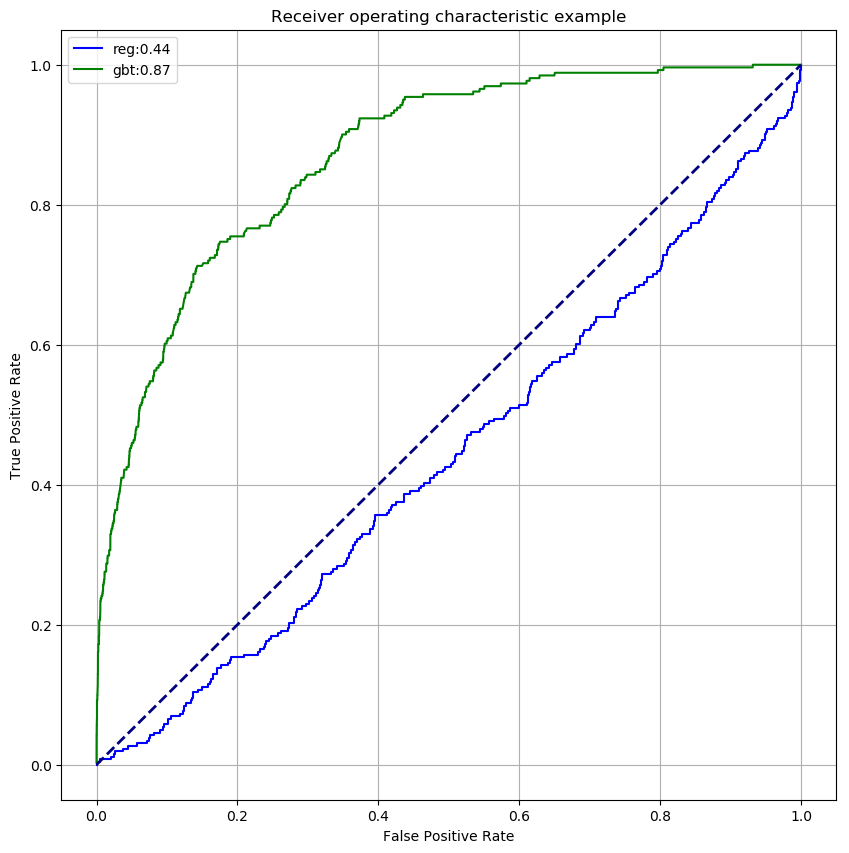

In [20]:
#%matplotlib inline
#import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.grid()
plt.show()

### Save predictions on train data for modelCalibration

In [21]:
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)

In [22]:
# save predictions to csv
df_result = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
df_result.to_csv("./data/predictions_train.csv", index=False)

In [23]:
df_result.head(2)

,label,predGbt,predReg
281,0,0.012370,0.007351
57,0,0.004365,0.233579


In [28]:
train_preds_0 = logreg.predict(X_train)
print(sum(train_preds_0))
train_preds_1 = gbt.predict(X_train)
print(sum(train_preds_1))
#train

0
133


In [33]:
#df_result.sort_values('label')
df_result.head()

,label,predGbt,predReg
281,0,0.012370,0.007351
57,0,0.004365,0.233579
273,0,0.015028,0.019901
725,0,0.022796,0.146835
55,1,0.110889,0.003938


In [45]:
cut = 0.5
prdGbt1 = df_result['predGbt'] > cut
labelTF = df_result['label'] == 1

In [52]:
np.logical_and(prdGbt1, labelTF)

281    False
57     False
273    False
725    False
55     False
43     False
120    False
547    False
337    False
376    False
446    False
598    False
842    False
753    False
388    False
269    False
993    False
494    False
491    False
269    False
342    False
908    False
531    False
401    False
195    False
225    False
818    False
547    False
540    False
407    False
       ...  
36     False
921    False
216    False
469    False
921    False
277    False
897    False
152    False
606    False
327    False
983    False
89     False
650    False
852    False
744     True
832    False
430    False
935    False
116    False
258    False
757    False
275    False
225    False
403    False
243    False
123    False
648    False
845    False
799    False
732    False
Name: predGbt, Length: 21700, dtype: bool

In [61]:
# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
TP = np.sum(np.logical_and(prdGbt1, labelTF))

# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(np.logical_not(prdGbt1), np.logical_not(labelTF)))

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(prdGbt1,  np.logical_not(labelTF)))

# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(np.logical_not(prdGbt1), labelTF))

print('TP: {}, FP: {}, TN: {}, FN: {})'.format(TP,FP,TN,FN))
TPR = TP/(TP+FN)

TP: 100, FP: 33, TN: 21003, FN: 564)


In [69]:
print(tabulate([['Actual no','TN','FP'],['Actual yes','FN','TP']],headers=['Pred no','Pred yes']))
print()
print()
print(tabulate([['Actual no',TN,FP],['Actual yes',FN,TP]],headers=['Pred no','Pred yes']))

            Pred no    Pred yes
----------  ---------  ----------
Actual no   TN         FP
Actual yes  FN         TP


              Pred no    Pred yes
----------  ---------  ----------
Actual no       21003          33
Actual yes        564         100


In [70]:
train_preds_0 = logreg.predict(X_train)
print(sum(train_preds_0))

0
